In [1]:
#Importing needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import time

torch.manual_seed(0)

In [2]:
#Plotting function
def view_classify(img, ps):

    ps = ps.cpu().data.numpy().squeeze()
    img= img.cpu().data.numpy()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.reshape(1, 28, 28).squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

In [3]:
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

trainset=datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader=DataLoader(trainset, batch_size=32, shuffle=True)

testset=datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader=DataLoader(testset, batch_size=32, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to MNIST_data/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST_data/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw



In [4]:
dataiter=iter(trainloader)
images, labels=dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


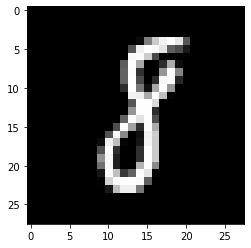

In [5]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [6]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1=nn.Conv2d(1, 32, 5, padding=1, stride=2)
        self.pool=nn.MaxPool2d(2,2)

        self.conv2=nn.Conv2d(32, 16, 5)
        self.fc1=nn.Linear(16*1*1, 128)
        self.fc2=nn.Linear(128, 64)
        self.fc3=nn.Linear(64,10)

    def forward(self, x):
        #print(x.shape)
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x=x.view(x.shape[0], -1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        #x=F.softmax(x, dim=1)
        return x

model=Network()

In [7]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda


Network(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [8]:
state_dict=torch.load('checkpoint.pth')
model.load_state_dict(state_dict)
print(model.load_state_dict(state_dict))

<All keys matched successfully>


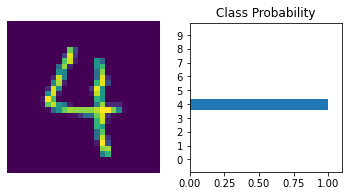

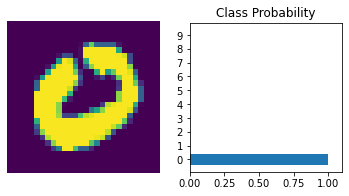

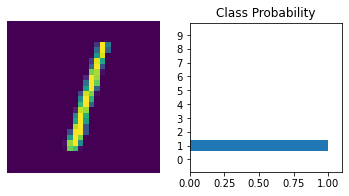

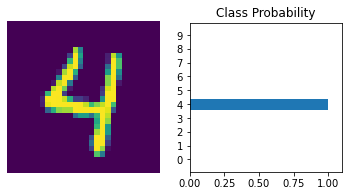

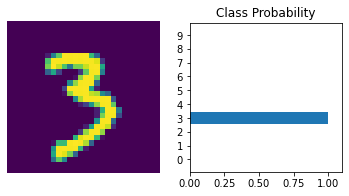

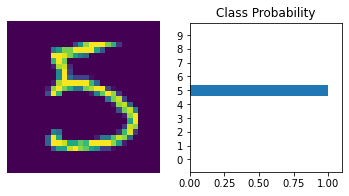

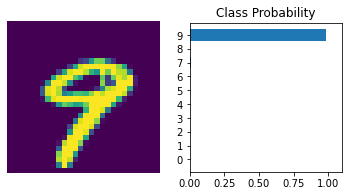

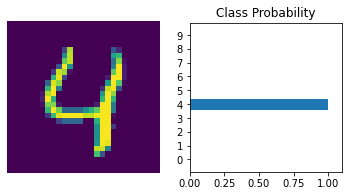

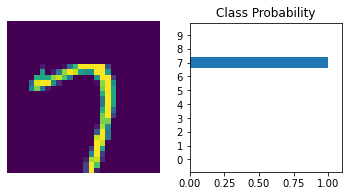

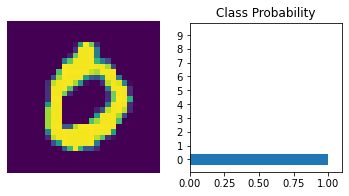

In [9]:
counter=0
while counter<10:
    index=np.random.randint(0,32)
    images, labels = next(iter(testloader))
    images=images.to(device)
    labels=labels.to(device)
    image=images[index]    
    logits = model.forward(image.view(1,1,28,28))
    ps = F.softmax(logits, dim=1)
    view_classify(image.view(1, 28, 28), ps)
    plt.show()
    time.sleep(1)
    counter+=1

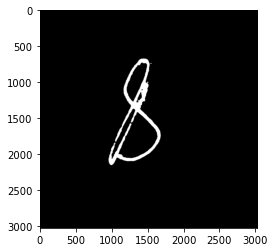

In [109]:
import cv2
import matplotlib.pyplot as plt
kernel=cv2.getStructuringElement(cv2.MORPH_CROSS, (15,15))
n8=cv2.imread('8.jpg')
bgr_n8=n8.copy()
bgr_n8=cv2.cvtColor(bgr_n8, cv2.COLOR_BGR2RGB)
gray_n8=n8.copy()
gray_n8=cv2.cvtColor(gray_n8, cv2.COLOR_BGR2GRAY)
retval, dst= cv2.threshold(gray_n8, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(dst, cmap='gray')

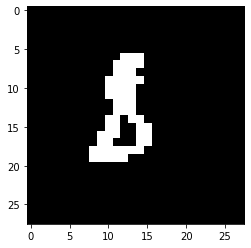

In [110]:
dst=cv2.dilate(dst, kernel, iterations=15)
dst=cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
dst=cv2.erode(dst, kernel, iterations=5)
dst=cv2.resize(dst, (28,28))
filename='output.png'
cv2.imwrite(filename, dst)
plt.imshow(dst, cmap='gray')

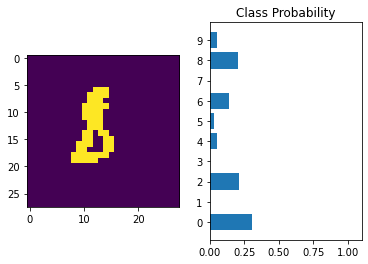

In [111]:
from PIL import Image
img_transformer=transforms.Compose([transforms.Grayscale(),transforms.Resize((28, 28)), 
                transforms.ToTensor(), 
                transforms.Normalize(mean=[(0.5)], std=[(0.5)])])

dst=Image.open('output.png')
input_tensor= img_transformer(dst)
input_batch=input_tensor.unsqueeze(0)
input_batch=input_batch.to(device)


output=model.forward(input_batch)
probability=F.softmax(output, dim=1)
probability = probability.cpu().data.numpy().squeeze()

plt.subplot(1,2,1)
plt.imshow(dst)
plt.subplot(1,2,2)
plt.barh(np.arange(10), probability)
plt.yticks(np.arange(10))
plt.title('Class Probability')
plt.xlim(0, 1.1)
plt.show()